Clean notebook that runs 10 random seed for Tucker with $K_M = 22, K_N = 4, K_P = 2, K_S=18$ and then aligns and orders by stability.

In [ ]:
!pip install pymongo wandb

In [ ]:
! git clone https://github.com/lindermanlab/dirichlet-tucker.git
! cd dirichlet-tucker; pip install -e .

fatal: destination path 'dirichlet-tucker' already exists and is not an empty directory.
Obtaining file:///content/dirichlet-tucker
  Preparing metadata (setup.py) ... done
  Attempting uninstall: dtd
    Found existing installation: dtd 0.0.1
    Uninstalling dtd-0.0.1:
      Successfully uninstalled dtd-0.0.1
  Running setup.py develop for dtd


In [ ]:
from dtd.model4d import DirichletTuckerDecomp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
import jax.numpy as jnp
import jax.random as jr
from tensorflow_probability.substrates import jax as tfp
from jax import jit
from tqdm.auto import trange

tfd = tfp.distributions
warnings.filterwarnings("ignore")

import bson
import click
import os
import numpy as np
import matplotlib.pyplot as plt
import wandb

import itertools as it
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix

from scipy.optimize import linear_sum_assignment

# class DirichletTuckerDecomp:

#     def __init__(self, C, K_M, K_N, K_P, K_S, alpha=1.1):
#         """Dirichlet-Tucker decomposition of a 4d tensor with 2 batch dimension (m, n)
#         and 2 event dimensions (p, s).

#         C: total counts for each (m,n) slice of the data tensor
#         K_M, K_N, K_P, K_S: dimension of factors for the M, N, P, and S axes, respectively.
#         alpha: concentration of Dirichlet prior. Assume shared by all axes.

#         """
#         self.C = C
#         self.K_M = K_M
#         self.K_N = K_N
#         self.K_P = K_P
#         self.K_S = K_S
#         self.alpha = alpha

#     def sample_params(self, key, M, N, P, S):
#         """Sample a data tensor and parameters from the model.

#         Args:
#         key: jr.PRNGKey
#         M, N, P, S: dimensions of the data

#         Returns:
#             params = (G, Psi, Phi, Theta, Lambda) where
#                 G: (K_M, K_N, K_P, K_S) core tensor
#                 Psi: (M, K_M) factor
#                 Phi: (N, K_N) factor
#                 Theta: (K_P, P) topic (note transposed!)
#                 Lambda: (K_S, S) topic (note transposed!)
#         """
#         K_M, K_N, K_P, K_S = self.K_M, self.K_N, self.K_P, self.K_S
#         k1, k2, k3, k4, k5 = jr.split(key, 5)

#         # Using TFP: This is stupidly slow for some reason!
#         # G = tfd.Dirichlet(self.alpha * jnp.ones(K_P * K_S)).sample(seed=k1, sample_shape=(K_M, K_N,)).reshape((K_M, K_N, K_P, K_S))
#         # Psi = tfd.Dirichlet(self.alpha * jnp.ones(K_M)).sample(seed=k2, sample_shape=(M,))
#         # Phi = tfd.Dirichlet(self.alpha * jnp.ones(K_N)).sample(seed=k3, sample_shape=(N,))
#         # Theta = tfd.Dirichlet(self.alpha * jnp.ones(P)).sample(seed=k4, sample_shape=(K_P,))
#         # Lambda = tfd.Dirichlet(self.alpha * jnp.ones(S)).sample(seed=k5, sample_shape=(K_S,))

#         # Using jax.random
#         G = jr.dirichlet(k1, self.alpha * jnp.ones(K_P * K_S), shape=(K_M, K_N,)).reshape((K_M, K_N, K_P, K_S))
#         Psi = jr.dirichlet(k2, self.alpha * jnp.ones(K_M), shape=(M,))
#         Phi = jr.dirichlet(k3, self.alpha * jnp.ones(K_N), shape=(N,))
#         Theta = jr.dirichlet(k4, self.alpha * jnp.ones(P), shape=(K_P,))
#         Lambda = jr.dirichlet(k5, self.alpha * jnp.ones(S), shape=(K_S,))
#         return (G, Psi, Phi, Theta, Lambda)

#     def sample_data(self, key, params):
#         """Sample a data tensor and parameters from the model.

#         key: jr.PRNGKey
#         params: tuple of params

#         returns:
#             X: (M, N, P) data tensor where shapes are determined by params.
#         """
#         # Sample data
#         probs = jnp.einsum('ijkl,mi,nj,kp,ls->mnps', *params)
#         X = tfd.Multinomial(self.C, probs=probs).sample(seed=key)
#         return X

#     # Now implement the EM algorithm
#     def e_step(self, X, mask, params):
#         """Compute posterior expected sufficient statistics of parameters.

#         X: (M, N, P, S) count tensor
#         mask: (M,N) binary matrix specifying which epochs are held-out for
#             which mice.
#         """
#         probs = jnp.einsum('ijkl,mi,nj,kp,ls->mnps', *params)
#         relative_probs = jnp.einsum('ijkl,mi,nj,kp,ls->ijklmnps', *params)
#         relative_probs /= probs
#         E_Z = X * mask[..., None, None] * relative_probs

#         # compute alpha_* given E[Z]
#         alpha_G = jnp.sum(E_Z, axis=(4,5,6,7))
#         alpha_Psi = jnp.sum(E_Z, axis=(1,2,3,5,6,7)).T
#         alpha_Phi = jnp.sum(E_Z, axis=(0,2,3,4,6,7)).T
#         alpha_Theta = jnp.sum(E_Z, axis=(0,1,3,4,5,7))
#         alpha_Lambda = jnp.sum(E_Z, axis=(0,1,2,4,5,6))
#         return alpha_G, alpha_Psi, alpha_Phi, alpha_Theta, alpha_Lambda

#     def _m_step_g(self, alpha_G):
#         """Maximize conditional distribution of core tensor.

#         alpha_G: (K_M, K_N, K_P, K_S)
#         """
#         alpha_post = self.alpha + alpha_G
#         # return tfd.Dirichlet(alpha_post).mode()
#         G_star = alpha_post - 1.0
#         G_star /= G_star.sum(axis=(2,3), keepdims=True)
#         return G_star

#     def _m_step_psi(self, alpha_Psi):
#         """Maximize conditional distribution of Psi factor.

#         alpha_Psi: (M, K_M)
#         """
#         alpha_post = self.alpha + alpha_Psi
#         return tfd.Dirichlet(alpha_post).mode()

#     def _m_step_phi(self, alpha_Phi):
#         """Maximize conditional distribution of Phi factor.

#         alpha_Phi: (N, K_N)
#         """
#         alpha_post = self.alpha + alpha_Phi
#         return tfd.Dirichlet(alpha_post).mode()

#     def _m_step_theta(self, alpha_Theta):
#         """Maximize conditional distribution of Theta factor.

#         alpha_Theta: (K_P, P)
#         """
#         alpha_post = self.alpha + alpha_Theta
#         return tfd.Dirichlet(alpha_post).mode()

#     def _m_step_lambda(self, alpha_Lambda):
#         """Maximize conditional distribution of Lambda factor.

#         alpha_Lambda: (K_S, S)
#         """
#         alpha_post = self.alpha + alpha_Lambda
#         return tfd.Dirichlet(alpha_post).mode()

#     def m_step(self, alpha_G, alpha_Psi, alpha_Phi, alpha_Theta, alpha_Lambda):
#         G = self._m_step_g(alpha_G)
#         Psi = self._m_step_psi(alpha_Psi)
#         Phi = self._m_step_phi(alpha_Phi)
#         Theta = self._m_step_theta(alpha_Theta)
#         Lambda = self._m_step_lambda(alpha_Lambda)
#         return G, Psi, Phi, Theta, Lambda

#     def heldout_log_likelihood(self, X, mask, params):
#         r"""Compute the log likelihood of the held-out entries in X

#         NOTE: Ignores the multinomial normalizing constant (C \choose x_1; x_2, ... x_N)
#         """
#         # Use `jnp.where` to avoid NonConcreteBooleanIndexError
#         probs = jnp.einsum('ijkl,mi,nj,kp,ls->mnps', *params)
#         return jnp.where(~mask, jnp.sum(X * jnp.log(probs), axis=(2,3)), 0.0).sum()

#     def log_prob(self, X, mask, params):
#         M, N, P, S = X.shape
#         G, Psi, Phi, Theta, Lambda = params

#         # log prior
#         G_flat = G.reshape((self.K_M, self.K_N, self.K_P * self.K_S))
#         lp = tfd.Dirichlet(self.alpha * jnp.ones(self.K_P * self.K_S)).log_prob(G_flat).sum()
#         lp += tfd.Dirichlet(self.alpha * jnp.ones(self.K_M)).log_prob(Psi).sum()
#         lp += tfd.Dirichlet(self.alpha * jnp.ones(self.K_N)).log_prob(Phi).sum()
#         lp += tfd.Dirichlet(self.alpha * jnp.ones(P)).log_prob(Theta).sum()
#         lp += tfd.Dirichlet(self.alpha * jnp.ones(S)).log_prob(Lambda).sum()

#         # log likelihood of observed data
#         # Use `jnp.where` to avoid NonConcreteBooleanIndexError
#         probs = jnp.einsum('ijkl,mi,nj,kp,ls->mnps', *params)
#         lp += jnp.where(mask, jnp.sum(X * jnp.log(probs), axis=(2,3)), 0.0).sum()
#         return lp

#     def reconstruct(self, params):
#         return self.C * jnp.einsum('ijkl,mi,nj,kp,ls->mnps', *params)

#     # Fit the model!
#     def fit(self, X, mask, init_params, num_iters, tol=1e-4):

#         @ jit
#         def em_step(X, mask, params):
#             E_params = self.e_step(X, mask, params)
#             params = self.m_step(*E_params)
#             lp = self.log_prob(X, mask, params)
#             return lp, params

#         # Initialize the recursion
#         params = init_params
#         lps = []
#         scale = X[mask].sum()
#         for itr in trange(num_iters):
#             lp, params = em_step(X, mask, params)
#             lps.append(lp)

#             if itr % 100 == 0:
#                 print("itr {:04d}: lp: {:.5f}".format(itr, lps[-1] / scale))

#             # Check for convergence of scaled LP
#             # NOTE: Sometimes individual EM steps change LP very little,
#             #       so we look at change in scaled LP over 100 steps instead.
#             if itr > 100 and abs(lps[-1] - lps[-100]) / scale < tol:
#                 print("converged at tolerance level", tol)
#                 break

#         return params, jnp.stack(lps)

In [ ]:
def load_data(data_dir):
    # Load te drug ids ((M,) array of ints)
    y = np.load(os.path.join(data_dir, "drug_ids.npy"))

    # read in behav data
    with open(os.path.join(data_dir, "behav_data.bson"), 'rb') as f:
        data = bson.decode_all(f.read())

    X = np.reshape(np.frombuffer(data[0]['Xb']['data'], dtype=np.float64), data[0]['Xb']['size'], order='F').astype(np.float32)

    # Behavior tensor X is mice x syllables x positions x epochs
    # Permute to mice x epochs x positions x syllables
    X = np.transpose(X, (0, 3, 2, 1))

    # Permute the syllables
    perm = np.array([2, 45, 32, 33, 20, 23, 31, 47, 6, 25, 10, 17, 42, 12, 30, 36, 28, 34, 49, 13, 44, 7, 16, 15, 29, 48, 37, 38, 8, 24, 39, 43, 1, 26, 11, 19, 9, 40, 27, 21, 3, 18, 35, 4, 14, 5, 41, 22, 46, 50]) - 1
    X = X[..., perm]
    return X, y


def make_mask(X, key=0, train_frac=0.8):
    """## Split the data into train and test"""
    M, N, P, S = X.shape
    key = jr.PRNGKey(key)
    mask = tfd.Bernoulli(probs=train_frac).sample(seed=key, sample_shape = (M, N)).astype(bool)
    return mask


def fit_model(key, X, mask, K_M, K_N, K_P, K_S, alpha, num_iters, tol):
    M, N, P, S = X.shape
    C = X[0,0].sum()

    # Construct a model
    model = DirichletTuckerDecomp(C, K_M, K_N, K_P, K_S, alpha=alpha)
    # Initialize the parameters randomly
    print("initializing model")
    init_params = model.sample_params(key, M, N, P, S)
    print("done")

    # Fit the model with EM
    params, lps = model.fit(X, mask, init_params, num_iters, tol=tol)

    return model, params, lps


def plot_results(X, y, model, params):
    # Compute the reconstruction
    X_hat = model.reconstruct(params)

    # Plot the true and reconstructed data for mouse `m`
    m = 0
    n = 0
    fig, axs = plt.subplots(3, 1)
    im = axs[0].imshow(X[m, n], aspect="auto", interpolation="none")
    plt.colorbar(im)
    im = axs[1].imshow(X_hat[m, n], aspect="auto", interpolation="none")
    plt.colorbar(im)
    im = axs[2].imshow(X[m, n] - X_hat[m, n], aspect="auto", interpolation="none")
    plt.colorbar(im)

    """### Look at the factors"""
    G, Psi, Phi, Theta, Lambda = params

    # Plot the position topics
    plt.figure()
    plt.imshow(Theta, aspect="auto", interpolation="none")
    plt.xlabel("position")
    plt.ylabel("topics")
    plt.colorbar()

    # Plot the syllable topics
    syll_groups = np.array([2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) -1
    group_bounds = np.cumsum(np.bincount(syll_groups)[:-1])

    plt.figure()
    plt.imshow(Lambda, aspect="auto", interpolation="none")
    for bound in group_bounds:
        plt.axvline(bound-.5, color='r')
    plt.xlabel("syllables")
    plt.ylabel("topics")
    plt.colorbar()

    # Plot the epoch loadings
    plt.figure()
    plt.imshow(Phi.T, aspect="auto", interpolation="none")
    plt.xlabel("epochs")
    plt.ylabel("loadings")
    plt.colorbar()

    # Plot the mouse loadings
    plt.figure()
    perm = jnp.argsort(y)
    bounds = jnp.cumsum(jnp.bincount(y)[1:-1])
    plt.imshow(Psi[perm], aspect="auto", interpolation="none")
    for bound in bounds:
        plt.axhline(bound, color='r')
    plt.xlabel("loadings")
    plt.ylabel("mice")
    plt.colorbar()


def evaluate_prediction(Psi, y):
    """### Classify drug labels"""

    # normalize weights and factors
    def normalize_weights(features):
        features -= features.mean(axis=0)
        features /= features.std(axis=0)
        return features

    parameters = {"C":10 ** np.linspace(-15,15,num=31)}
    lr = LogisticRegression()
    gridsearch = GridSearchCV(lr, parameters)
    gridsearch.fit(normalize_weights(Psi), y)

    acc = gridsearch.best_score_
    classifier = gridsearch.best_estimator_
    y_pred = cross_val_predict(classifier, normalize_weights(Psi), y=y)
    confusion_mat = confusion_matrix(y, y_pred)

    return acc, confusion_mat

## set hyperparams

In [ ]:
data_dir = "/content/drive/MyDrive/Luo+Linderman 5HT files/data-redo/"
km = 22
kn = 4
kp = 4
ks = 22
alpha = 1.1
num_iters = 2000 # should be 2000
tol = 1e-4

# Split the data deterministically
X, y = load_data(data_dir)
mask = make_mask(X, key=0)

In [ ]:
num_seeds = 5
seeds = np.arange(50,50 + num_seeds)
model_dict = {} #save all the results into model_dict
for s in seeds:
  key = jr.PRNGKey(s)
  model, params, lps = fit_model(key, X, mask, km, kn, kp, ks, alpha, num_iters, tol)
  model_dict[s] = params

initializing model
done


  0%|          | 0/2000 [00:00<?, ?it/s]

itr 0000: lp: -5.86891
itr 0100: lp: -5.37095
itr 0200: lp: -5.34258
itr 0300: lp: -5.33625
itr 0400: lp: -5.33163
itr 0500: lp: -5.32861
itr 0600: lp: -5.32668
itr 0700: lp: -5.32501
itr 0800: lp: -5.32398
itr 0900: lp: -5.32309
itr 1000: lp: -5.32219
itr 1100: lp: -5.32152
itr 1200: lp: -5.32106
itr 1300: lp: -5.32046
itr 1400: lp: -5.31994
itr 1500: lp: -5.31940
itr 1600: lp: -5.31894
converged at tolerance level 0.0001
initializing model
done


  0%|          | 0/2000 [00:00<?, ?it/s]

itr 0000: lp: -5.86922
itr 0100: lp: -5.35239
itr 0200: lp: -5.32898
itr 0300: lp: -5.32422
itr 0400: lp: -5.32273
itr 0500: lp: -5.32200
itr 0600: lp: -5.32160
itr 0700: lp: -5.32123
converged at tolerance level 0.0001
initializing model
done


  0%|          | 0/2000 [00:00<?, ?it/s]

itr 0000: lp: -5.86867
itr 0100: lp: -5.35449
itr 0200: lp: -5.33271
itr 0300: lp: -5.32567
itr 0400: lp: -5.32253
itr 0500: lp: -5.32108
itr 0600: lp: -5.32037
itr 0700: lp: -5.31949
itr 0800: lp: -5.31901
converged at tolerance level 0.0001
initializing model
done


  0%|          | 0/2000 [00:00<?, ?it/s]

itr 0000: lp: -5.86891
itr 0100: lp: -5.35035
itr 0200: lp: -5.33029
itr 0300: lp: -5.32536
itr 0400: lp: -5.32316
itr 0500: lp: -5.32189
itr 0600: lp: -5.32124
itr 0700: lp: -5.32018
itr 0800: lp: -5.31934
itr 0900: lp: -5.31860
itr 1000: lp: -5.31814
itr 1100: lp: -5.31796
converged at tolerance level 0.0001
initializing model
done


  0%|          | 0/2000 [00:00<?, ?it/s]

itr 0000: lp: -5.86931
itr 0100: lp: -5.35313
itr 0200: lp: -5.33109
itr 0300: lp: -5.32550
itr 0400: lp: -5.32334
itr 0500: lp: -5.32220
itr 0600: lp: -5.32169
itr 0700: lp: -5.32134
itr 0800: lp: -5.32085
itr 0900: lp: -5.32041
converged at tolerance level 0.0001


In [ ]:
# stability functions
from scipy.spatial import distance

def make_cost_matrix_gen(params1, params2):
    """
    params1: tuple
    params2: tuple
    """
    k = params1[0].shape[0]
    cost = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            sim = np.prod([1 - distance.cosine(p1[i], p2[j]) for p1, p2 in zip(params1, params2)])
            cost[i,j] += -sim
    return cost

def find_permutation_gen(params1, params2):
    _, perm = linear_sum_assignment(make_cost_matrix_gen(params1, params2))
    return perm

def score_similarity(factors):
  """
  For each of the K factors

  gives a similarity score
  """
  scores = []
  n = len(factors)
  K = factors[0].shape[0]
  for k in range(K): #loop over the factors
    cur_score = []
    for i in range(n):
      for j in np.arange(i+1,n):
        cur_score.append(1 - distance.cosine(factors[i][k],factors[j][k] ))
    cur_score = np.array(cur_score)
    scores.append(np.mean(cur_score))
  return np.array(scores)

def align_factors_tucker(model_dict):
  """
  Aligns the factors to the first factor

  Takes in a model_dict, which is a dictionary.
  The keys are ints, corresponding to jr.seeds
  The values are G,W,E,S tuples (from the Tucker decomp)
  """
  new_model_dict = {}
  keys = list(model_dict.keys())
  n = len(keys)
  # align the factors
  G, W, E, P, S = model_dict[keys[0]]
  new_model_dict[keys[0]] = (np.array(G), np.array(W), np.array(E), np.array(P), np.array(S))
  for key in keys[1:]:
    # do the bipartite matching problem (make sure that the factors are k x d)
    G2, W2, E2, P2, S2 = model_dict[key]
    # the different perms
    mice_perm = find_permutation_gen((W.T,), (W2.T,))
    epoch_perm = find_permutation_gen((E.T,), (E2.T,))
    pos_perm = find_permutation_gen((P,), (P2,))
    syl_perm = find_permutation_gen((S,), (S2,))
    G2 = G2[mice_perm]
    G2 = G2[:, epoch_perm, ...]
    G2 = G2[..., pos_perm, :]
    G2 = G2[..., syl_perm]
    new_model_dict[key] = (np.array(G2), np.array(W2[:, mice_perm]),
                           np.array(E2[:, epoch_perm]),
                           np.array(P2[pos_perm]), np.array(S2[syl_perm]))
  # order the factors by stability
  aligned_mouse_factors = [new_model_dict[key][1].T for key in keys]
  mouse_sim_order = np.argsort(score_similarity(aligned_mouse_factors))[::-1]

  aligned_epoch_factors = [new_model_dict[key][2].T for key in keys]
  epoch_sim_order = np.argsort(score_similarity(aligned_epoch_factors))[::-1]

  aligned_pos_factors = [new_model_dict[key][3] for key in keys]
  pos_sim_order = np.argsort(score_similarity(aligned_pos_factors))[::-1]

  aligned_syl_factors = [new_model_dict[key][4] for key in keys]
  syl_sim_order = np.argsort(score_similarity(aligned_syl_factors))[::-1]

  for key in keys:
    G, W, E, P, S = new_model_dict[key]
    G = G[mouse_sim_order]
    G = G[:, epoch_sim_order, ...]
    G = G[..., pos_sim_order, :]
    G = G[..., syl_sim_order]
    new_model_dict[key] = (G, W[:, mouse_sim_order], E[:, epoch_sim_order], P[pos_sim_order], S[syl_sim_order])
  return new_model_dict

In [ ]:
new_model_dict = align_factors_tucker(model_dict)
# new model dict orders factors (mouse, epoch, syllable) by stability
# aligns by similarity

## Visualizing the factors

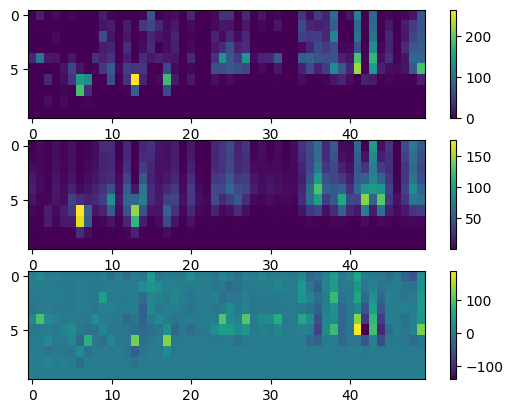

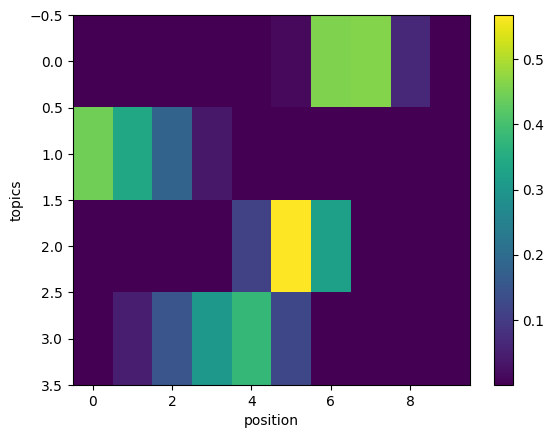

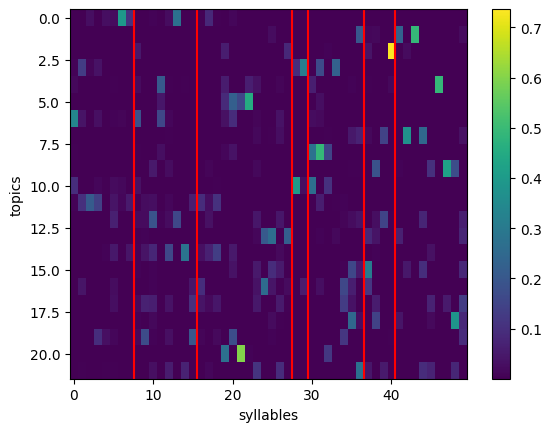

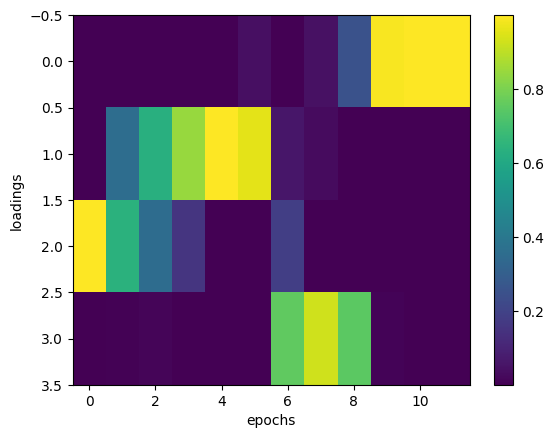

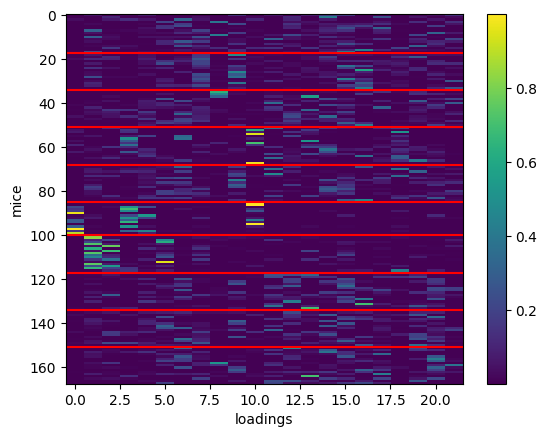

In [ ]:
plot_results(X,y,model, new_model_dict[seeds[0]])

Text(0.5, 0.98, 'epoch factors')

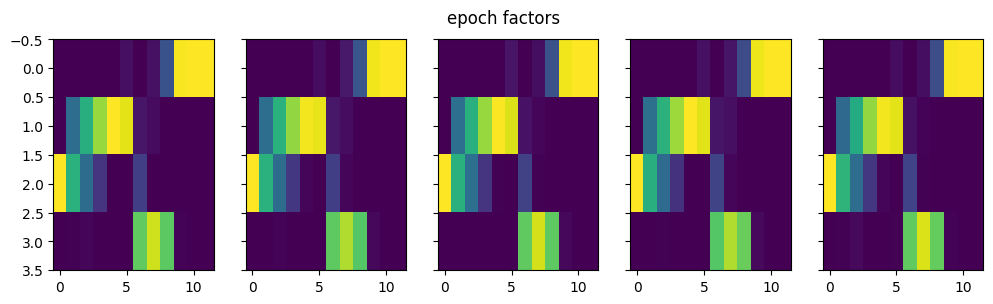

In [ ]:
fig, axs = plt.subplots(1, num_seeds, sharey=True, figsize=(12, 3))

for i in range(num_seeds):
  axs[i].imshow(new_model_dict[seeds[i]][2].T, aspect="auto", interpolation="none")

fig.suptitle("epoch factors")

Text(0.5, 0.98, 'Mouse factors')

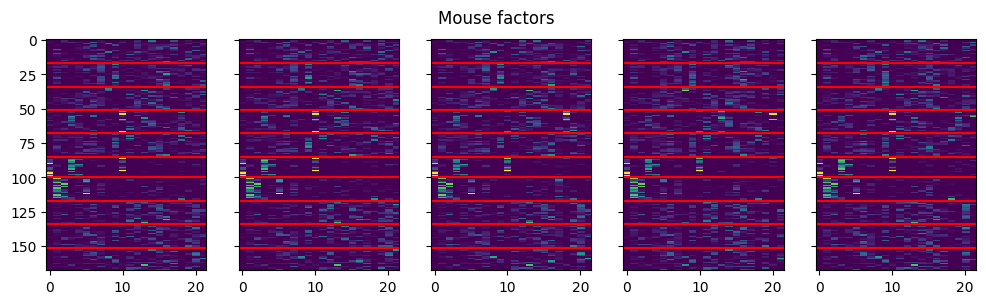

In [ ]:
fig, axs = plt.subplots(1, num_seeds, sharey=True, figsize=(12, 3))

for i in range(num_seeds):
  perm = jnp.argsort(y)
  bounds = jnp.cumsum(jnp.bincount(y)[1:-1])

  axs[i].imshow(new_model_dict[seeds[i]][1][perm], aspect="auto", interpolation="none")
  for bound in bounds:
      axs[i-1].axhline(bound, color='r')

fig.suptitle("Mouse factors")

#### syllable factors

Text(0.5, 0.98, 'syllable factors')

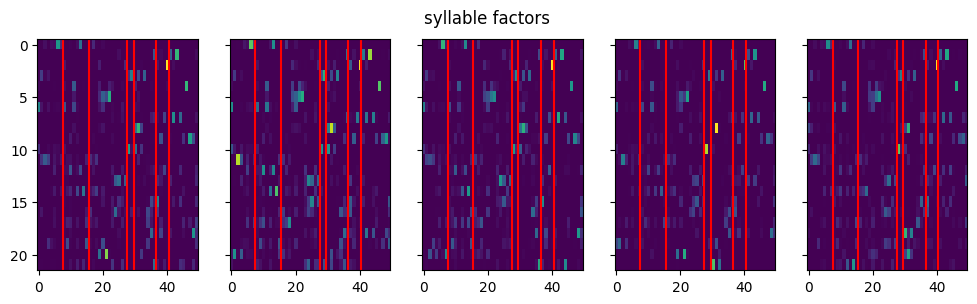

In [ ]:
# Plot the syllable topics
syll_groups = np.array([2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]) -1
group_bounds = np.cumsum(np.bincount(syll_groups)[:-1])

fig, axs = plt.subplots(1, num_seeds, sharey=True, figsize=(12, 3))

for i in range(num_seeds):
  axs[i].imshow(new_model_dict[seeds[i]][-1], aspect="auto", interpolation="none")
  for bound in group_bounds:
    axs[i].axvline(bound-.5, color='r')

fig.suptitle("syllable factors")

#### position factors

Text(0.5, 0.98, 'position factors')

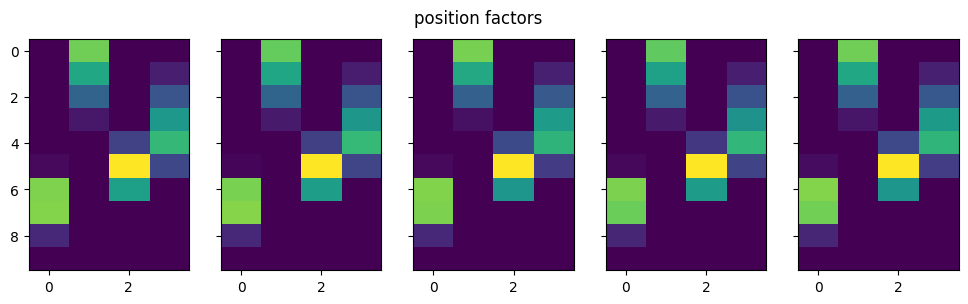

In [ ]:
fig, axs = plt.subplots(1, num_seeds, sharey=True, figsize=(12, 3))

for i in range(num_seeds):
  axs[i].imshow(new_model_dict[seeds[i]][3].T, aspect="auto", interpolation="none")

fig.suptitle("position factors")

## Write the factors to a google drive

In [ ]:
SAVE_DIREC = "/content/drive/MyDrive/Luo+Linderman 5HT files/joint_factors/"
import time
import datetime
import scipy

In [ ]:
# creating a directory
timestamp = time.time()
datetime_str = datetime.datetime.fromtimestamp(timestamp).isoformat()
save_direc = SAVE_DIREC + datetime_str
os.makedirs(save_direc, mode=0o777)

In [ ]:
for key in new_model_dict.keys():
  G, W, E, P, S = new_model_dict[key]
  scipy.io.savemat(save_direc + f"/behav_seed_{int(key)}.mat",
      {"G": G,
        "W": W,
        "E": E,
        "P":P,
        "S": S})